In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# --- I. Setup and Load Files ---
years = list(range(2013, 2023))
base_path = "C:/Users/jason/OneDrive - The Pennsylvania State University/DAAN 881, Data Drive Decision Making/Project/Auto Data/SC/"

# Unified structure to hold data
data_by_year = {}

for year in years:
    crash_fp = os.path.join(base_path, f"Statewide {year}.xlsx")
    units_fp = os.path.join(base_path, f"Statewide {year} UNITS.xlsx")

    crash_df = pd.read_excel(crash_fp, dtype=str)
    units_df = pd.read_excel(units_fp, dtype=str)

    data_by_year[year] = {
        "crash": crash_df,
        "units": units_df
    }

In [7]:
# --- II. Define Column Mapping, Filters, Cleaners ---

# Unified column mapping
columns_to_keep = [
    'crash_id', 'state', 'crash_date', 'hour', 'county_fips',
    'fatalities', 'injuries', 'severity_level', 'opioid_flag', 'any_drug_flag',
    'alcohol_flag', 'young_driver_flag', 'mature_driver_flag', 'driver_age', 'driver_sex'
]

# Drug code translation
DRUG_CODES = {
    'A': 'Amphetamines', 'C': 'Cocaine', 'M': 'Marijuana', 'O': 'Opiates', 'P': 'PCP'
}

RACE_CODES = {
    'A': 'Asian/Pacific Islander', 'W': 'White', 'B': 'Black', 'H': 'Hispanic',
    'MR': 'Multi-Racial', 'U': 'Unknown', 'O': 'Other'
}

# Helper to parse date

def parse_date(row):
    try:
        return pd.to_datetime(f"{row['collision_date']} {row.get('collision_time', '00:00')}")
    except:
        return pd.NaT

# Clean and transform yearly data
combined_data = []

for year, dfs in data_by_year.items():
    crash = dfs['crash'].copy()
    units = dfs['units'].copy()

    crash.columns = crash.columns.str.lower().str.strip()
    units.columns = units.columns.str.lower().str.strip()

    # Derive crash_date and hour
    crash['crash_date'] = pd.to_datetime(crash['date'], errors='coerce')
    crash['hour'] = crash['time'].str.extract(r'(\d{1,2})').astype(float)

    # Add year info and FIPS
    crash['state'] = 'SC'
    crash['county_fips'] = crash['county'].str.zfill(3)

    # Extract crash_id
    crash['crash_id'] = crash['crash_number']

    # Merge unit info
    merged = pd.merge(crash, units, on='crash_number', suffixes=('', '_unit'))

    # Clean demographic fields
    merged['driver_age'] = pd.to_numeric(merged['driver_age'], errors='coerce')
    merged['driver_sex'] = merged['driver_sex'].map({'M': 'Male', 'F': 'Female'}).fillna('Unknown')
    merged['young_driver_flag'] = (merged['driver_age'] < 21).astype(int)
    merged['mature_driver_flag'] = (merged['driver_age'] >= 65).astype(int)

    # Fatalities and injuries
    merged['fatalities'] = pd.to_numeric(merged['persons_killed'], errors='coerce').fillna(0)
    merged['injuries'] = pd.to_numeric(merged['persons_injured'], errors='coerce').fillna(0)

    # Severity level: 2=fatal, 1=injury, 0=property-only
    merged['severity_level'] = np.select(
        [merged['fatalities'] > 0, merged['injuries'] > 0],
        [2, 1], default=0
    )

    # Opioid, drug, alcohol flags
    merged['opioid_flag'] = merged['drug_test_results'].str.contains('O', na=False).astype(int)
    merged['any_drug_flag'] = merged['drug_test_results'].str.contains(r'[ACMOP]', na=False).astype(int)
    merged['alcohol_flag'] = merged['alcohol_test_results'].str.contains('Y', na=False).astype(int)

    combined_data.append(merged)

In [8]:
# --- III. Merge All Years ---

df_all_years = pd.concat(combined_data, ignore_index=True)

In [9]:
# --- IV. Modeling Prep ---
df_model = df_all_years.dropna(subset=['crash_date'])
df_model = df_model.sort_values('crash_date')
train_size = int(len(df_model) * 0.7)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

# Example model: Predict opioid_flag
X = train[['driver_age', 'injuries', 'fatalities']].fillna(0)
y = train['opioid_flag']
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# Evaluate
X_test = test[['driver_age', 'injuries', 'fatalities']].fillna(0)
y_test = test['opioid_flag']
pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    757455
           1       0.00      0.00      0.00       351

    accuracy                           1.00    757806
   macro avg       0.50      0.50      0.50    757806
weighted avg       1.00      1.00      1.00    757806



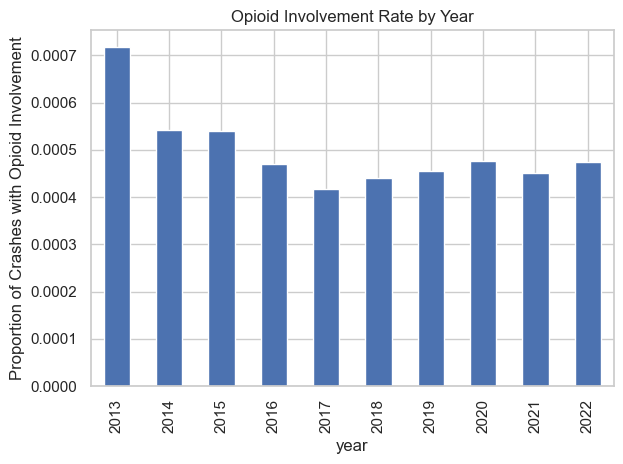

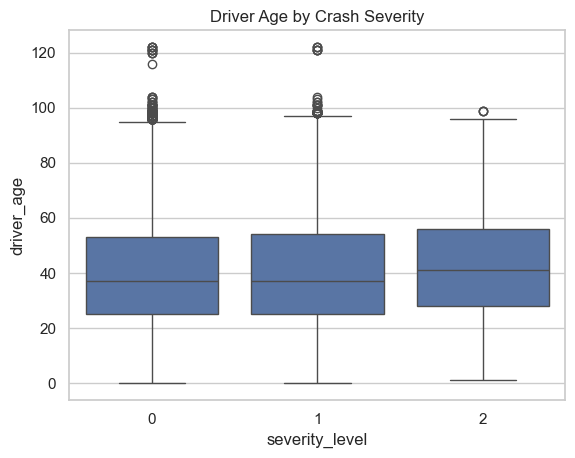

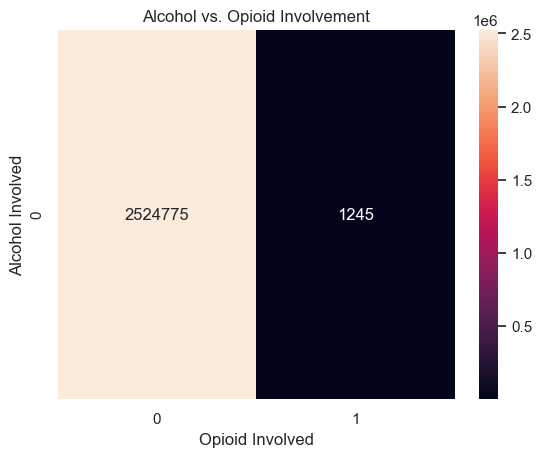

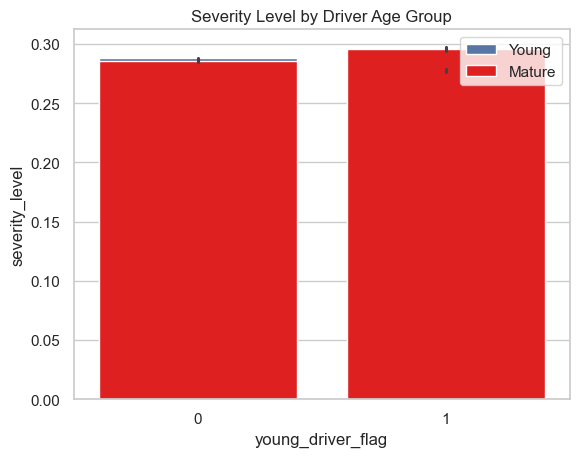

In [10]:
# --- V. Visualizations ---
sns.set(style="whitegrid")

# 1. Opioid trend by year
df_all_years['year'] = pd.to_datetime(df_all_years['crash_date']).dt.year
drug_trend = df_all_years.groupby('year')['opioid_flag'].mean()
drug_trend.plot(kind='bar', title='Opioid Involvement Rate by Year')
plt.ylabel("Proportion of Crashes with Opioid Involvement")
plt.tight_layout()
plt.show()

# 2. Severity by Age Group
sns.boxplot(x='severity_level', y='driver_age', data=df_all_years)
plt.title('Driver Age by Crash Severity')
plt.show()

# 3. Alcohol vs. Opioid Co-Involvement
sns.heatmap(pd.crosstab(df_all_years['alcohol_flag'], df_all_years['opioid_flag']), annot=True, fmt='d')
plt.title("Alcohol vs. Opioid Involvement")
plt.xlabel("Opioid Involved")
plt.ylabel("Alcohol Involved")
plt.show()

# 4. Young vs. Mature Driver Risk
sns.barplot(data=df_all_years, x='young_driver_flag', y='severity_level', estimator=np.mean, label='Young')
sns.barplot(data=df_all_years, x='mature_driver_flag', y='severity_level', estimator=np.mean, color='red', label='Mature')
plt.legend()
plt.title('Severity Level by Driver Age Group')
plt.show()